# Capítulo 6

Alguns dos métodos neste notebook são mais intensivos computacionalmente (e.g., best subset selection), então faz sentido limitar o número de features que queremos usar. Isso vai ser definido globalmente pela variável `max_feature` a seguir.

In [85]:
max_features = 5

## 6.5.1 Subset Selection Methods

In [86]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd 
import math
import random
import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import *
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA 
from sklearn.cross_decomposition import PLSRegression, PLSSVD
from sklearn.preprocessing import StandardScaler, scale 
from sklearn import linear_model 
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV

Vamos abrir o dataset `Hitters`, com o objetivo de prever `Salary` usando estatísticas associadas a performance dos jogadores de baseball. Para rodar nossos modelos, vamos também= retirar os NAs.

In [87]:
Hitters = pd.read_csv('Hitters.csv', header=0, na_values='NA')

In [88]:
Hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N


In [89]:
print(Hitters.shape)

(322, 20)


In [90]:
Hitters = Hitters.dropna().reset_index(drop=True)
print(Hitters.shape)

(263, 20)


Em primeiro lugar, precisamos lidar com variáveis categóricas: `League`, `Division` e `NewLeague`. Como de praxe, vamos transformá-las em dummies.

In [91]:
y = Hitters["Salary"]

dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X = Hitters.drop(['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')#Dataframe X sem essas colunas
X = pd.concat([X,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [83]:
print(dummies)

     League_A  League_N  Division_E  Division_W  NewLeague_A  NewLeague_N
0           0         1           0           1            0            1
1           1         0           0           1            1            0
2           0         1           1           0            0            1
3           0         1           1           0            0            1
4           1         0           0           1            1            0
..        ...       ...         ...         ...          ...          ...
258         0         1           1           0            0            1
259         1         0           1           0            1            0
260         1         0           0           1            1            0
261         1         0           1           0            1            0
262         1         0           0           1            1            0

[263 rows x 6 columns]


Para fazer best subset selection, vamos precisar de duas funções: uma que roda o modelo (no caso, OLS) e retorna o RSS (i.e., $n \times \text{MSE}$), e outra que, para um certo número de features $K$, escolhe o melhor modelo (i.e., com menor RSS).

In [11]:
def getRSS(y, X, feature_list):
    model = sm.OLS(y, X[list(feature_list)]).fit()
    RSS = ((model.predict(X[list(feature_list)]) - y) ** 2).sum()
    return {'model':model, "RSS":RSS}

def bestModel(y, X, K):
    results = []
    for c in itertools.combinations(X.columns, K):
        results.append(getRSS(y, X, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()]
    return best_model

In [109]:
print(len(X.columns))

19


In [110]:
models = pd.DataFrame(columns=["RSS", "model"])
for i in range(1,(7)):
    models.loc[i] = bestModel(y, X, i)

Vamos analisar alguns dos modelos encontrados.

In [13]:
print(models.loc[1, 'model'].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.665
Model:                            OLS   Adj. R-squared (uncentered):              0.663
Method:                 Least Squares   F-statistic:                              519.2
Date:                Sat, 06 Apr 2024   Prob (F-statistic):                    4.20e-64
Time:                        03:58:15   Log-Likelihood:                         -1952.4
No. Observations:                 263   AIC:                                      3907.
Df Residuals:                     262   BIC:                                      3910.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [14]:
print(models.loc[2, 'model'].summary())

                                 OLS Regression Results                                
Dep. Variable:                 Salary   R-squared (uncentered):                   0.761
Model:                            OLS   Adj. R-squared (uncentered):              0.760
Method:                 Least Squares   F-statistic:                              416.7
Date:                Sat, 06 Apr 2024   Prob (F-statistic):                    5.80e-82
Time:                        03:58:19   Log-Likelihood:                         -1907.6
No. Observations:                 263   AIC:                                      3819.
Df Residuals:                     261   BIC:                                      3826.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Como se comporta RSS (e outra medida de erro, digamos $R^2$ ajustado) na medida em que o número de features aumenta?

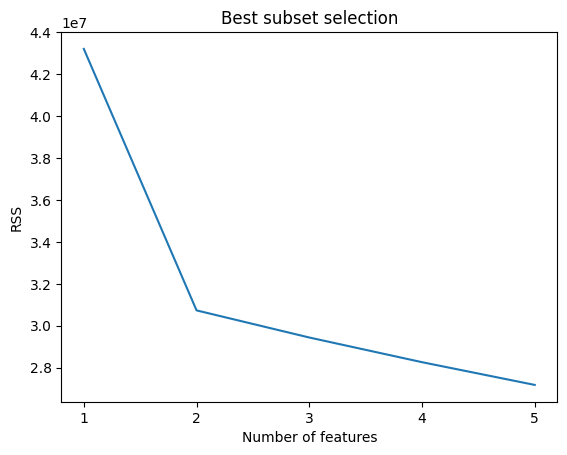

In [15]:
plt.figure()
plt.plot(models["RSS"])
plt.title("Best subset selection")
plt.xlabel('Number of features')
plt.ylabel('RSS')
plt.xticks(range(1,max_features+1))
plt.show()

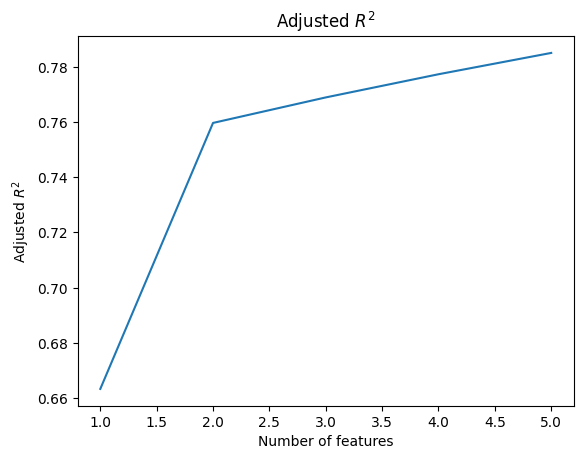

In [16]:
rsquared_adj = models.apply(lambda row: row[1].rsquared_adj, axis=1) 

plt.figure()
plt.title("Adjusted $R^2$")
plt.plot(rsquared_adj)
plt.xlabel('Number of features')
plt.ylabel('Adjusted $R^2$')
plt.show()

Parece que best subset com mais features traz resultados melhores. Por um lado, isso significa que estamos procurando mais combinações de features, mas também estamos mais arriscados em cometer overfitting. De fato, como estamos olhando para RSS no treino, é claro que ele precisa cair quanto mais features incluirmos.

## 6.5.2 Forward and Backward Stepwise Selection

Podemos ajustar o código da seção anterior para relizar forward e backward selection também. A única mudança é o conjunto de possíveis features que vamos considerar. Por conta disso, vamos reutilizar a função `getRSS()` e nos preocupar em restringir a lista de previsores possíveis.

### Forward Stepwise Selection

Para forward stepwise selection, sabemos que depois da inclusão de uma feature ela sempre estará presente no conjunto de features

In [17]:
def forward_select(y, X, feature_list):
    remaining_predictors = [p for p in X.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS(y, X, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [18]:
models_forward = pd.DataFrame(columns=["RSS", "model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models_forward.loc[i] = forward_select(y, X, feature_list)
    feature_list = models_forward.loc[i]["model"].model.exog_names#Retorna os preditores

In [19]:
print(models_forward.loc[8,'model'].params)

Hits            6.906587
CRBI            0.527752
PutOuts         0.274904
AtBat          -2.061610
Division_E    122.658126
Walks           6.455809
CWalks         -0.810584
CRuns           0.706071
dtype: float64


In [20]:
# we can compare the results of best subset selection and the forward selection
print('Features escolhidas por best subset (nos dados de treino):')
print(models.loc[max_features, 'model'].params)
print('\n')
print('Features escolhidas por forward stepwise (nos dados de treino):')
print(models_forward.loc[max_features, 'model'].params)

Features escolhidas por best subset (nos dados de treino):
AtBat          -1.571703
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
Division_E    124.035287
dtype: float64


Features escolhidas por forward stepwise (nos dados de treino):
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
AtBat          -1.571703
Division_E    124.035287
dtype: float64


Nesse caso, obtivemos o mesmo resultado em ambos os casos, mas forward stepwise é ordens de vezes mais rápido.

### Backward Stepwise Selection

Backward stepwise é parecido, mas começamos com todas as features. A função `backward_select()` abaixo acha o melhor conjunto de features excluindo uma feature por vez. 

In [30]:
def backward_select(y, X, feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS(y, X, combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

Aí, em cada etapa, retiramos uma das features da lista escolhida por `backward_select()`.

In [31]:
models_backward = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))
feature_list = X.columns
models_backward.loc[len(feature_list)] = getRSS(y, X, feature_list)

while(len(feature_list) > 1):
    models_backward.loc[len(feature_list)-1] = backward_select(y, X, feature_list)
    feature_list = models_backward.loc[len(feature_list)-1]["model"].model.exog_names

print(models_backward.loc[max_features, "model"].params)

AtBat     -1.899448
Hits       7.754626
Walks      3.687280
CRuns      0.624463
PutOuts    0.301334
dtype: float64


Note que, agora, temos previsores diferentes sendo escolhidos. Podemos também comparar o RSS de treino em todos os casos.

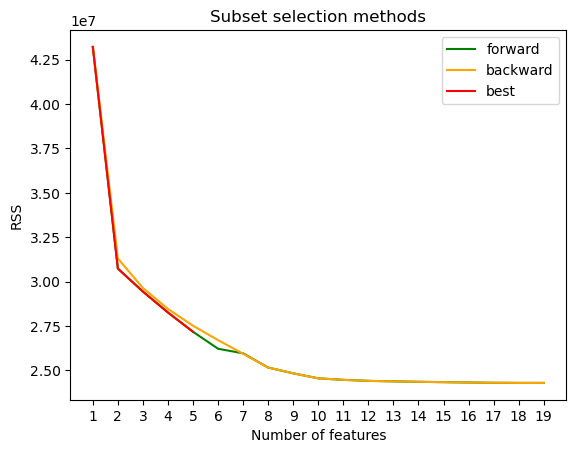

In [610]:
plt.figure()
plt.plot(models_forward["RSS"], color='green', label='forward')
plt.plot(models_backward["RSS"], color='orange', label='backward')
plt.plot(models["RSS"], color='red', label='best')
plt.title("Subset selection methods")
plt.xlabel('Number of features')
plt.ylabel('RSS')
plt.xticks(range(1,X.shape[1]+1))
plt.legend()
plt.show()

## 6.5.3 Escolhendo modelos usando conjunto de validação ou validação cruzada

Anteriormente, definimos o "melhor" modelo usando alguma estatística no conjunto de treino (e.g., $R^2$, $R^2$ ajustado, AIC, BIC, etc). Essas estatísticas são motivadas teoricamente, mas frequentemente preferimos uma opção que não dependa de hipóteses teóricas. Em várias circunstâncias, usar validação cruzada (CV) ou um conjunto de validação é uma boa opção para isso.

Começamos escolhendo um seed e particionando os dados em treino e teste. Vamos usar 70% dos dados para treino e 30% para teste. Comumente, tomamos algo como 80%-20% ou 90%-10%. Isso depende também da quantidade de dados que temos a nosso dispor. Se for algo enorme, podemos até tomar 95%-5%.

### Conjunto de validação

A abordadgem do conjunto de validacao consiste em aleoatorizar as n observações e em seguida dividir em conjunto de 
treino e conjunto de teste. O conjunto de teste e o conjunto de validação.

![Alt text](validationSet.PNG)




In [25]:
np.random.seed(seed = 1)

train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3])#remeber that y is your response array
test_index = np.invert(train_index)

X_train= X[train_index]
y_train = y[train_index]
X_test = X[test_index]
y_test = y[test_index]

In [22]:
np.random.seed(seed = 1)

train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3])#remeber that y is your response array
test_index = np.invert(train_index)
print(train_index)

[ True False  True  True  True  True  True  True  True  True  True  True
  True False  True  True  True  True  True  True False False  True  True
 False False  True  True  True False  True  True False  True  True  True
  True False  True False False False  True False  True  True False  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True False  True False  True
  True False  True  True False  True False False False  True False  True
  True False  True False  True  True  True False  True  True  True  True
 False  True  True  True  True  True False  True False  True  True False
  True False  True  True False  True  True False False False False  True
  True  True  True  True False  True  True False  True  True  True False
  True  True False  True False  True False False  True  True  True  True
  True  True  True False  True  True  True False  True  True  True False
  True  True False False  True  True  True False  T

train_index = np.random.choice([True, False], size = len(y), replace = True, p = [0.7, 0.3]): This line generates an array of boolean values (True or False) with the same length as the dataset y. The np.random.choice function is used here to randomly choose between True and False for each element in the array. The parameter size = len(y) specifies the length of the array to be equal to the length of y, which presumably is your dataset. The replace = True parameter indicates that the same value can be selected multiple times. The p = [0.7, 0.3] parameter sets the probability of selecting True as 70% and False as 30%. This effectively means that approximately 70% of the dataset will be used for training, as indicated by True values in the train_index array.

Vamos sutilmente adaptar algumas das funções que já desenvolvemos para fazer best, forward e backward selection, mas agora nos dados de teste.

In [26]:
def getRSS_test(y_train, X_train, y_test, X_test,  feature_list):
    model = sm.OLS(y_train, X_train[list(feature_list)]).fit()
    RSS = ((model.predict(X_test[list(feature_list)]) - y_test) ** 2).sum()#Rss de teste
    return {'model':model, "RSS":RSS}
#Em todas as funções de escolher os melhores preditores nos iremos escolher baseado no conjunto de teste. Pois as funoces
#sao treinadas e em seguida testadas.
def bestModel_test(y_train, X_train, y_test, X_test, K):
    results = []
    for c in itertools.combinations(X_train.columns, K):
        results.append(getRSS_test(y_train, X_train, y_test, X_test, c))     
    model_all =  pd.DataFrame(results)
    
    best_model = model_all.loc[model_all["RSS"].idxmin()] ## this could be modified to have the top several models
    return best_model


def forward_select_test(y_train, X_train, y_test, X_test,  feature_list):
    remaining_predictors = [p for p in X_train.columns if p not in feature_list]
    results = []
    for p in remaining_predictors:
        results.append(getRSS_test(y_train, X_train, y_test, X_test, feature_list+[p]))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model

def backward_select_test(y_train, X_train, y_test, X_test,  feature_list):
    results = []
    for combo in itertools.combinations(feature_list, len(feature_list)-1):
        results.append(getRSS_test(y_train, X_train, y_test, X_test,  combo))

    models = pd.DataFrame(results)
    best_model = models.loc[models['RSS'].idxmin()]
    return best_model  

In [27]:
models_best_test = pd.DataFrame(columns=["RSS", "model"])
for i in range(1,(max_features+1)):
    models_best_test.loc[i] = bestModel_test(y_train, X_train, y_test, X_test, i)
    
models_forward_test = pd.DataFrame(columns=["RSS", "model"])
feature_list = []
for i in range(1,len(X.columns)+1):
    models_forward_test.loc[i] = forward_select_test(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = models_forward_test.loc[i]["model"].model.exog_names
    
models_backward_test = pd.DataFrame(columns=["RSS", "model"], index = range(1,len(X.columns)))
feature_list = X.columns
models_backward_test.loc[len(feature_list)] = getRSS(y, X, feature_list)

while(len(feature_list) > 1):
    models_backward_test.loc[len(feature_list)-1] = backward_select_test(y_train, X_train, y_test, X_test,  feature_list)
    feature_list = models_backward_test.loc[len(feature_list)-1]["model"].model.exog_names

In [32]:
print('Features escolhidas por best subset (nos dados de treino):')
print(models.loc[max_features, 'model'].params)
print('\n')
print('Features escolhidas por forward stepwise (nos dados de treino):')
print(models_forward.loc[max_features, 'model'].params)
print('\n')
print('Features escolhidas por backward stepwise (nos dados de treino):')
print(models_backward.loc[max_features, 'model'].params)
print('\n')
print('Features escolhidas por best subset (nos dados de teste):')
print(models_best_test.loc[max_features, 'model'].params)
print('\n')
print('Features escolhidas por forward stepwise (nos dados de teste):')
print(models_forward_test.loc[max_features, 'model'].params)
print('\n')
print('Features escolhidas por backward stepwise (nos dados de teste):')
print(models_backward_test.loc[max_features, 'model'].params)

Features escolhidas por best subset (nos dados de treino):
AtBat          -1.571703
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
Division_E    124.035287
dtype: float64


Features escolhidas por forward stepwise (nos dados de treino):
Hits            7.443980
CRBI            0.684000
PutOuts         0.288405
AtBat          -1.571703
Division_E    124.035287
dtype: float64


Features escolhidas por backward stepwise (nos dados de treino):
AtBat     -1.899448
Hits       7.754626
Walks      3.687280
CRuns      0.624463
PutOuts    0.301334
dtype: float64


Features escolhidas por best subset (nos dados de teste):
Walks           4.717943
CAtBat         -0.293365
CHits           1.343465
PutOuts         0.257045
Division_E    140.433617
dtype: float64


Features escolhidas por forward stepwise (nos dados de teste):
CRuns      0.626680
Hits       8.062047
PutOuts    0.227555
AtBat     -1.948979
Walks      3.644881
dtype: float64


Features escolhidas por backwar

Usando forward e backward selection no conjunto de teste, podemos escolher qual é o número ideal de features a ser incluída. Note que não necessariamente esse número (ou o conjunto escolhido!) são iguais.

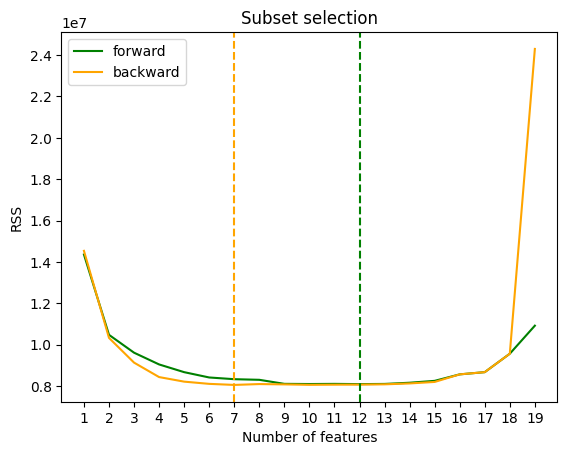

In [33]:
plt.figure()
plt.title("Subset selection")
plt.plot(models_forward_test["RSS"], color='green', label='forward')
plt.plot(models_backward_test["RSS"], color='orange', label='backward')
plt.xlabel('Number of features')
plt.ylabel('RSS')
plt.axvline(models_forward_test["RSS"].astype('float').idxmin(), color = 'green', linestyle='dashed')
plt.axvline(models_backward_test["RSS"].astype('float').idxmin(), color = 'orange', linestyle='dashed')
plt.legend()
plt.xticks(range(1,X.shape[1]+1))
plt.show()

### Cross-Validation

Usar CV aqui não é tão diferente da ideia de conjunto de validação. Ao invés de usar um conjunto fixo de validação, vamos particionar o dataset em $K$ folds, treinar em $K-1$ e testar no fold restante, e tirar a média sobre todas as $K$ possibilidades para o fold de teste. Há duas vantagens em usar CV: (i) teremos uma avaliação de métrica para cada fold, então serão $K$ métricas (mesmo que altamente correlacionadas); e (ii) o tamanho do conjunto de treino será mais perto do original, o que atenua um viés da diferença de tamanho de treino.

In [60]:
k = 10
np.random.seed(seed = 21)
train_index = np.random.choice(k, size = len(y), replace = True)
#Esse codigo indica os indices referentes ao conjunto de validacao dos k fold. (ou seja um fold apenas). Assim escolhemos diversos valores
#de maneira aletatoria. Esse fold e a o fold de validacao.

print(type(train_index))
cv_errors = pd.DataFrame(columns=range(1,k+1), index=range(1,len(X.columns) + 1))
print(cv_errors[1][1])
print(X.shape)

<class 'numpy.ndarray'>
nan
(263, 19)


### K-fold CV

Aqui temos uma abordagem chamada k-fold CV. Nessa abordagem iremos aleatorizar o data-set , e em sem seguida dividir
em k-folds. Apos fazer isso iremos treinar o modelo em k-1, e testar em 1. Iremos fazer isso repetidamente ou seja, iremos testar k vezes como 1 fold e treinar k vezes com tamanho k-1. Estimamos o erro de teste fazendo uma media do MSE em cada fold.

![Alt text](cvkfold.png)


#### Acessando valores de um dataframe a parte de outro daframe X[x]

Antes de defato analisar o codigo, vamos analisar uma tecnica muito util em pandas que refere-se acessar os valores de um dataframe a partir dos valores de um array com valores que sao True ou False.
Basicamenta passando o segundo como indice do primeiro.
Outra ideia importante e entender que podemos tambem iterar por um dataframe que ira sempre fazer uma comparacao.

In [75]:
X1 = [[1,2,3],[4,5,6],[7,8,9],[11,12,13]]
par = [1,1,2,2]
par = pd.Series(par)
#Definindo esses vetores como dataframe
X1 = pd.DataFrame(X1)

for i in range(1,3):
    print(X1[par == 2])#Retorna a serie X c



    0   1   2
2   7   8   9
3  11  12  13
    0   1   2
2   7   8   9
3  11  12  13


Como se pode ver, o que esta acontecendo ali e o seguinte, primeiro sera iterado por par, e toda vez que o indice de par for igual a 2, sera retornado o indice do vetor par
correspondente a onde essa condicao e valida. Isso sera feita ate o ultimo elemento de par em em seguida sera retornado X

Vamos olhar para os erros de CV para forward selection.

In [37]:
models_cv = pd.DataFrame(columns=["RSS", "model"])
#Esse loop for serva para tomar os valores referntes ao conjunto de validacao.
for j in range(1,k+1):
    feature_list = []
    #Esse loop for que varia de i, ate p+1, serve para tomar todos os modelos modelos possiveis utilizando fowartstepwise.
    for i in range(1,len(X.columns)+1):
        models_cv.loc[i] = forward_select_test(y[train_index!= (j-1)], X[train_index != (j-1)], 
                                                     y[train_index == (j-1)],X[train_index == (j-1)], 
                                                     feature_list)
        
        cv_errors[j][i] = models_cv.loc[i]["RSS"]
        feature_list = models_cv.loc[i]["model"].model.exog_names

### Explicao CV com foward selection

Aqui iremos variar de j=1, a k, esse serve para referir-se aos folds. No for de i, serve para escolhermos entre os p+1 modelos, ou seja melhor modelo com um parametro
melhor modelo com 2 e assim sucessivamente. O melhor modelo e o que obteve o melhor valor no fold de validacao. A iteracao em i sera replicada k vezes, ou seja sera analisada
em cada fold. Assim podemos gerar uma tabela onde cada linha represenhta o melhor modelo com um parametro, testado em cada fold. A primeira linha representa o melhor modelo de um parametro testada no fold 1, a segunda linha o melhor modelo com dois parametros testado no fold 2, e assim sucessivamente. 

Por fim podemos tirar uma media em cada linha represennta o erro CV e ve qual e a melhor combinacao que obteve o melhor resultado.

#### media.mean(axis =1): Serve para calcular a media de cada linha do dataframe

In [48]:
x = [[1,2,3],[4,5,6],[7,8,9]]
media = pd.DataFrame(columns=["f1","f2","f3"])
cont = 1
for i in x:
    media.loc[cont] = i
    cont=cont+1


print(media.mean(axis=1))


1    2.0
2    5.0
3    8.0
dtype: float64


DataFrame Column Access: In pandas, columns are accessed by their names, not by integer indices (unless the columns are specifically named with integers). Your DataFrame media has columns named "f1", "f2", and "f3". So, to access a column, you should use one of these names.

media.mean(axis=1) ira gerar a media de cada linha do dataframe

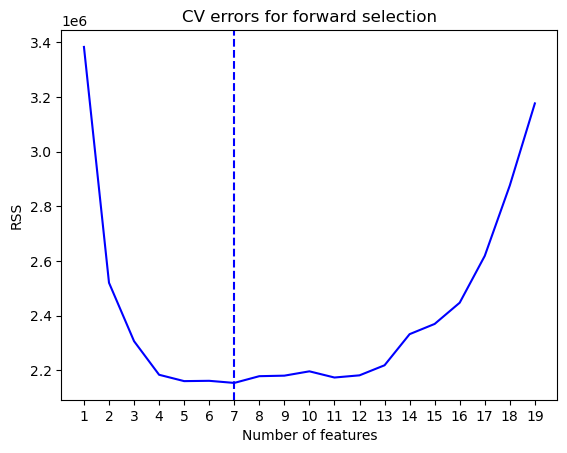

In [620]:
cv_errors_mean = cv_errors.mean(axis = 1)
plt.figure()
plt.plot(cv_errors_mean, color = 'blue')
plt.title("CV errors for forward selection")
plt.xlabel('Number of features')
plt.ylabel('RSS')
plt.axvline(cv_errors_mean.idxmin(), color = 'blue', linestyle='dashed')
plt.xticks(range(1,X.shape[1]+1))
plt.show()

Note que com 4 features já temos um modelo com performance razoável, sendo bem mais simples. Em geral, isso é preferível. A partir daí, podemos analisar quem são as features e quais são as estatísticas encontradas para esse modelo.

In [621]:
models_cv.loc[4, "model"].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Salary   R-squared (uncentered):                   0.771
Model:                            OLS   Adj. R-squared (uncentered):              0.767
Method:                 Least Squares   F-statistic:                              194.1
Date:                Thu, 10 Nov 2022   Prob (F-statistic):                    1.19e-72
Time:                        14:39:38   Log-Likelihood:                         -1704.3
No. Observations:                 235   AIC:                                      3417.
Df Residuals:                     231   BIC:                                      3430.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Walks          6.1303      0.877      6.989      0.000       4.402       7.859
CHits          1.3842      0.352      3.937      0.000       0.692       2.077
CAtBat        -0.2996      0.099     -3.018      0.003      -0.495      -0.104
PutOuts        0.2774      0.080      3.464      0.001       0.120       0.435
==============================================================================
Omnibus:                       91.710   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              553.972
Skew:                           1.401   Prob(JB):                    5.09e-121
Kurtosis:                       9.981   Cond. No.                         143.
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6.5.2 Ridge Regression and the Lasso

Ridge e lasso são dois métodos de regularização que ajudam a previnir overfitting penalizando os coeficientes $\beta_j$ (com perda $l_2$ no caso de ridge e $l_1$ no caso de lasso) e, quando $p>n$, estabilizam regressão linear. Por outro lado, ambos dependem de um parâmetro $\lambda$ que mede a força da penalização nos coeficientes. Para escolher esse parâmetro, vamos tentar olhar para o erro de teste estimado com diferentes escolhas de $\lambda$. Para isso, usamos CV ou um conjunto de validação.

In [93]:
Hitters = pd.read_csv('Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True)
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])

y = Hitters.Salary  # the response variable 
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

In [94]:
X.shape

(263, 19)

### Ridge Regression

Primeiro, especificamos os possíveis valores de $\lambda$ (que, infelizmente, são achamados de `alpha` na documentação do sklearn, então vamos seguir com esse nome de variável). Eles vão de $10^{5}$ até $10^{-2}$.

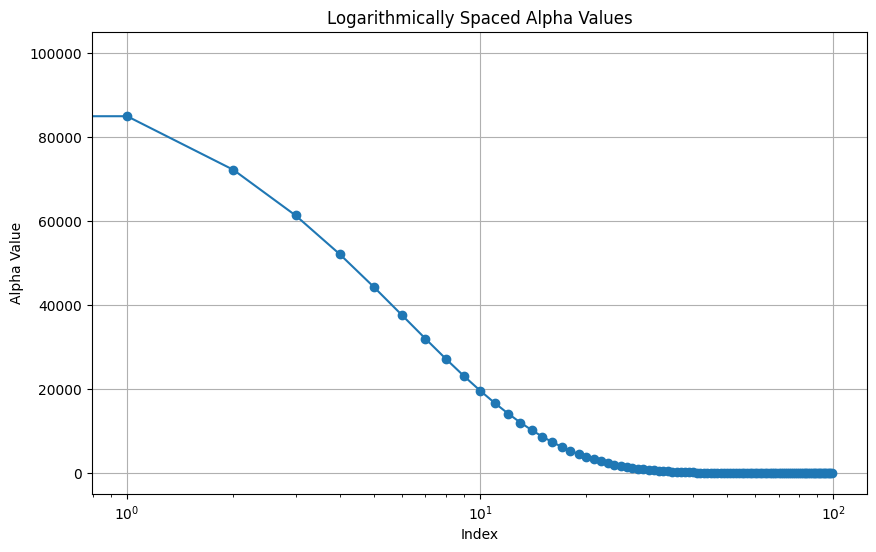

In [95]:
import numpy as np
import matplotlib.pyplot as plt

alphas = 10**np.linspace(5, -2, 100)

plt.figure(figsize=(10, 6))
plt.plot(alphas, 'o-')
plt.xscale('log')
plt.xlabel('Index')
plt.ylabel('Alpha Value')
plt.title('Logarithmically Spaced Alpha Values')
plt.grid(True)
plt.show()


In [96]:
print(np.linspace(5,-2,100))

[ 5.          4.92929293  4.85858586  4.78787879  4.71717172  4.64646465
  4.57575758  4.50505051  4.43434343  4.36363636  4.29292929  4.22222222
  4.15151515  4.08080808  4.01010101  3.93939394  3.86868687  3.7979798
  3.72727273  3.65656566  3.58585859  3.51515152  3.44444444  3.37373737
  3.3030303   3.23232323  3.16161616  3.09090909  3.02020202  2.94949495
  2.87878788  2.80808081  2.73737374  2.66666667  2.5959596   2.52525253
  2.45454545  2.38383838  2.31313131  2.24242424  2.17171717  2.1010101
  2.03030303  1.95959596  1.88888889  1.81818182  1.74747475  1.67676768
  1.60606061  1.53535354  1.46464646  1.39393939  1.32323232  1.25252525
  1.18181818  1.11111111  1.04040404  0.96969697  0.8989899   0.82828283
  0.75757576  0.68686869  0.61616162  0.54545455  0.47474747  0.4040404
  0.33333333  0.26262626  0.19191919  0.12121212  0.05050505 -0.02020202
 -0.09090909 -0.16161616 -0.23232323 -0.3030303  -0.37373737 -0.44444444
 -0.51515152 -0.58585859 -0.65656566 -0.72727273 -0.79

In [624]:
alphas = 10**np.linspace(5,-2,100)
print(alphas)

[1.00000000e+05 8.49753436e+04 7.22080902e+04 6.13590727e+04
 5.21400829e+04 4.43062146e+04 3.76493581e+04 3.19926714e+04
 2.71858824e+04 2.31012970e+04 1.96304065e+04 1.66810054e+04
 1.41747416e+04 1.20450354e+04 1.02353102e+04 8.69749003e+03
 7.39072203e+03 6.28029144e+03 5.33669923e+03 4.53487851e+03
 3.85352859e+03 3.27454916e+03 2.78255940e+03 2.36448941e+03
 2.00923300e+03 1.70735265e+03 1.45082878e+03 1.23284674e+03
 1.04761575e+03 8.90215085e+02 7.56463328e+02 6.42807312e+02
 5.46227722e+02 4.64158883e+02 3.94420606e+02 3.35160265e+02
 2.84803587e+02 2.42012826e+02 2.05651231e+02 1.74752840e+02
 1.48496826e+02 1.26185688e+02 1.07226722e+02 9.11162756e+01
 7.74263683e+01 6.57933225e+01 5.59081018e+01 4.75081016e+01
 4.03701726e+01 3.43046929e+01 2.91505306e+01 2.47707636e+01
 2.10490414e+01 1.78864953e+01 1.51991108e+01 1.29154967e+01
 1.09749877e+01 9.32603347e+00 7.92482898e+00 6.73415066e+00
 5.72236766e+00 4.86260158e+00 4.13201240e+00 3.51119173e+00
 2.98364724e+00 2.535364

Para cada `alpha`, temos um vetor de coeficientes associado a ridge regression. Vamos salvar cada um dos 19 parâmetros e o intercepto. Note que, antes de rodar a regressão, vamos normalizar as features.

In [99]:
ridge_pipeline = make_pipeline(StandardScaler(with_mean=False), Ridge(fit_intercept=True))

coeffs = []
intercepts = []

for alpha in alphas * len(X):
    ridge_pipeline[1].set_params(alpha=alpha)#Esta definindo o valor de alfa(lambda) para etapa de plotar ridge regression
    ridge_pipeline[1].fit(ridge_pipeline[0].fit_transform(X), y)
    coeffs.append(ridge_pipeline[1].coef_)
    intercepts.append(ridge_pipeline[1].intercept_)

In [100]:
print(ridge_pipeline)

Pipeline(steps=[('standardscaler', StandardScaler(with_mean=False)),
                ('ridge', Ridge(alpha=2.63))])


In [102]:
print(len(coeffs),len(intercepts))

100 100


Como os coeficientes variam de acordo com `alpha`? Como maior `alpha` implica em maior penalização, quanto maior `alpha` mais perto de zero os coeficientes deveriam ser.

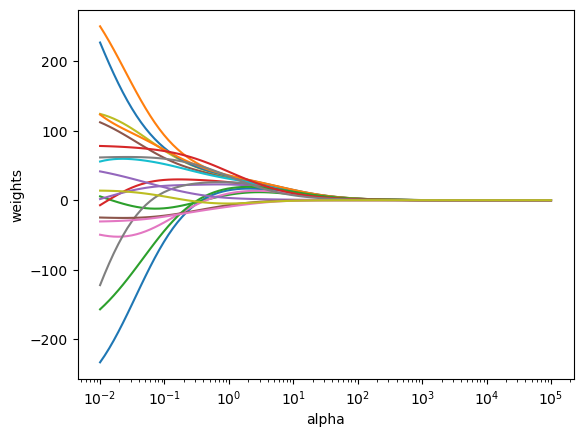

In [626]:
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log') 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

Como discutimos, quanto maior `alpha`, maior a penalização, e mais perto de zero ficará a norma $l_2$ dos coeficientes.

In [103]:
print("Norma dos coeficientes:")
print(f"Alpha {alphas[0]}: {np.sqrt(np.dot(coeffs[0], coeffs[0]))}")
print(f"Alpha {alphas[49]}: {np.sqrt(np.dot(coeffs[49], coeffs[49]))}")
print(f"Alpha {alphas[99]}: {np.sqrt(np.dot(coeffs[99], coeffs[99]))}")

Norma dos coeficientes:
Alpha 100000.0: 0.007877935402928384
Alpha 34.30469286314919: 19.04037146372709
Alpha 0.01: 518.950727619106


Se escolhermos algum desses valores para `alpha`, que tipo de erro podemos esperar num conjunto de dados que não foi usado para o treino?

In [104]:
np.random.seed(2023)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [105]:
alpha = 10

ridge_pipeline = make_pipeline(StandardScaler(with_mean=False), Ridge(fit_intercept=True))
ridge_pipeline[1].set_params(alpha=alpha * len(X_train))
ridge_pipeline[1].fit(ridge_pipeline[0].fit_transform(X_train), y_train)

preds = ridge_pipeline.predict(X_test)
print(f"\nAlpha: {alpha}; MSE: {mean_squared_error(y_test, preds)}")


Alpha: 10; MSE: 191257.6957245578


Ok, mas essa escolha foi arbitrária. Como podemos fazer uma escolha informada de `alpha`? Vamos usar CV (no treino) para encontrar uma boa escolha de `alpha`.

In [106]:
ridge_pipeline = make_pipeline(StandardScaler(with_mean=False), RidgeCV(alphas, scoring='neg_mean_squared_error', cv = 5))

ridge_pipeline[1].fit(ridge_pipeline[0].fit_transform(X_train), y_train)
ridgecv_model.alpha_/len(X_train)

NameError: name 'ridgecv_model' is not defined

In [644]:
ridge_best_pipeline = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=ridgecv_model.alpha_))
ridge_best_pipeline[1].fit(ridge_best_pipeline[0].fit_transform(X_train), y_train)
mean_squared_error(y_test, ridge_best_pipeline.predict(X_test))

186992.21203884968

Ou seja, o erro de teste escolhendo `alpha` via 5-fold CV é de, aproximadamente, 186992. 

Como isso se compara com regressão linear? Esse é o caso em que $\lambda = 0$.

In [645]:
ridge_best_pipeline = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=0))
ridge_best_pipeline[1].fit(ridge_best_pipeline[0].fit_transform(X_train), y_train)
mean_squared_error(y_test, ridge_best_pipeline.predict(X_test))

203435.22390131888

Supondo que não tínhamos acesso aos dados de teste, será que usando CV escolhemos um bom $\lambda$? Vamos plotar o MSE no teste para cada valor de $\lambda$, junto com o $\lambda$ escolhido via CV (no treino).

In [646]:
mses = []
for alpha in alphas:
    ridge_best_pipeline = make_pipeline(StandardScaler(with_mean=False), Ridge(alpha=alpha * len(X_train)))
    ridge_best_pipeline[1].fit(ridge_best_pipeline[0].fit_transform(X_train), y_train)
    mses.append(mean_squared_error(y_test, ridge_best_pipeline.predict(X_test)))

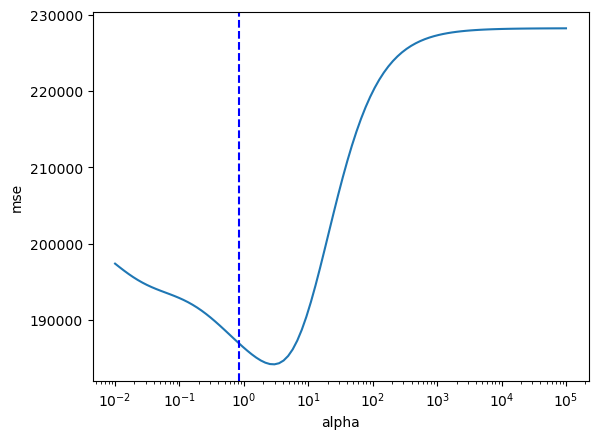

In [647]:
ax = plt.gca()
ax.plot(alphas, mses)
ax.set_xscale('log') 
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.axvline(ridgecv_model.alpha_/len(X_train), color = 'blue', linestyle='dashed')
plt.show()

Note também que os coefficientes de ridge podem ser pequenos mas praticamente nunca são exatamente zero.

In [648]:
pd.Series(ridge_best_pipeline[1].coef_/ridge_best_pipeline[0].scale_, index=X.columns)

AtBat           -1.406447
Hits             4.529248
HmRun           -4.766105
Runs            -1.825338
RBI              3.864779
Walks            5.702985
Years          -10.379917
CAtBat          -0.028983
CHits            0.214157
CHmRun           0.818471
CRuns            0.950398
CRBI            -0.089123
CWalks          -0.659550
PutOuts          0.385951
Assists          0.046703
Errors           0.850294
League_A       -12.534083
Division_E     107.453120
NewLeague_A      9.843507
dtype: float64

###  The Lasso
#### We saw that ridge regression with a wise choice of λ can outperform least squares as well as the null model on the Hitters data set. We now ask whether the lasso can yield either a more accurate or a more interpretable model than ridge regression.

In [649]:
np.random.seed(2023)
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [650]:
coeffs = []

for alpha in alphas:
    lasso_pipeline = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=alpha * np.sqrt(len(X_train)), max_iter=100000))
    lasso_pipeline[1].fit(lasso_pipeline[0].fit_transform(X_train), y_train)
#     mses.append(mean_squared_error(y_test, ridge_best_pipeline.predict(X_test)))
    coeffs.append(lasso_pipeline[1].coef_)

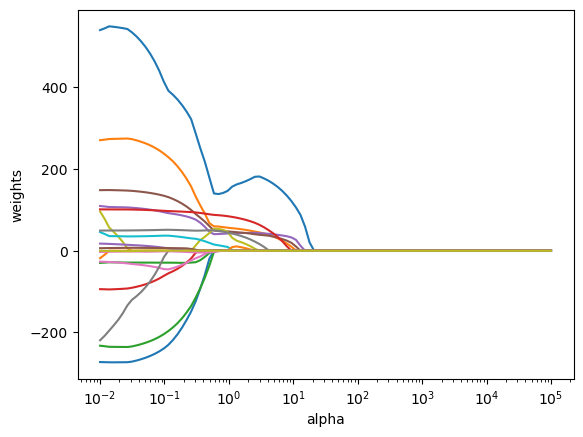

In [651]:
ax = plt.gca()
ax.plot(alphas, coeffs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.show()

In [652]:
lasso_cv_pipeline = make_pipeline(StandardScaler(with_mean=False), LassoCV(fit_intercept=True, alphas=[10, 100, 200], cv = 5))
lasso_cv_pipeline[1].fit(lasso_cv_pipeline[0].fit_transform(X_train), y_train)
lasso_cv_pipeline[1].alpha_

10

In [653]:
lasso_best_pipeline = make_pipeline(StandardScaler(with_mean=False), Lasso(alpha=lasso_cv_pipeline[1].alpha_, max_iter=100000))
lasso_best_pipeline[1].fit(lasso_best_pipeline[0].fit_transform(X_train), y_train)
mean_squared_error(y_test, lasso_best_pipeline.predict(X_test))

198495.31638501224

Ou seja, o MSE de lasso escolhendo $\lambda$ via CV é 198341, relativamente perto do MSE de ridge com $\lambda$ escolhido via CV, de 186993. Mas uma vantagem de lasso é que ele zera, exatamente, alguns coeficientes, que portanto podem ser descartados da regressão. Note também que o MSE do lasso, mesmo com menos regressores, é melhor do que a regressão linear com todos os regressores.

In [654]:
pd.Series(lasso_best_pipeline[1].coef_/lasso_best_pipeline[0].scale_, index=X.columns)

AtBat          -0.000000
Hits            1.324238
HmRun          -0.000000
Runs            0.000000
RBI             1.567334
Walks           2.207064
Years          -0.000000
CAtBat          0.000000
CHits           0.085394
CHmRun          0.164289
CRuns           0.436017
CRBI            0.000000
CWalks         -0.000000
PutOuts         0.350064
Assists        -0.000000
Errors          0.000000
League_A       -2.830753
Division_E     96.847279
NewLeague_A    -0.000000
dtype: float64

## 6.5.3 Regressão em componentes principais (PCR) e mínimos quadrados parciais (PLS)

### Regressão em componentes principais (PCR)

Para rodar uma regressão em componentes principais, vamos primeiro encontrar os componentes principais (via PCA) e depois usá-los como features numa regressão. Continuaremos usando o dataset `Hitters`, tentando prever a variável `Salary`. Como antes, vamos começar processando os dados: removendo NAs e transformando as variáveis categóricas em dummies.

In [667]:
Hitters = pd.read_csv('../data/Hitters.csv', header=0, na_values='NA')
Hitters = Hitters.dropna().reset_index(drop=True)
y = Hitters.Salary
dummies = pd.get_dummies(Hitters[['League', 'Division', 'NewLeague']])
X_prep = Hitters.drop (['Salary', 'League', 'Division', 'NewLeague'], axis = 1).astype('float64')
X = pd.concat([X_prep,  dummies[['League_A', 'Division_E', 'NewLeague_A']]], axis=1)

Encontrar os componentes principais é fácil usando a função `PCA()`. Note que primeiro devemos normalizar as features para que isso não afete indevidamente o resultado.

Quantos PCs devemos escolher? Há diferentes maneiras de se tomar essa decisão. Aqui, vamos usar CV. Primeiro dividimos os dados em treino e teste, e depois usamos CV nos dados de treino para ver qual é o número máximo de PCs que faz sentido escolher.

In [668]:
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2023)

In [669]:
def pcr(X, y, pc_max):
    pca = PCA()
    X_pca = pca.fit_transform(scale(X))[:, :pc_max]

    linear_regression = linear_model.LinearRegression()
    linear_regression.fit(X_pca, y)

    y_train = linear_regression.predict(X_pca)
    y_cv = cross_val_predict(linear_regression, X_pca, y, cv=20)

    score_train = r2_score(y, y_train)
    score_cv = r2_score(y, y_cv)
    
    mse_train = mean_squared_error(y, y_train)
    mse_cv = mean_squared_error(y, y_cv)

    return(y_cv, score_train, score_cv, mse_train, mse_cv)

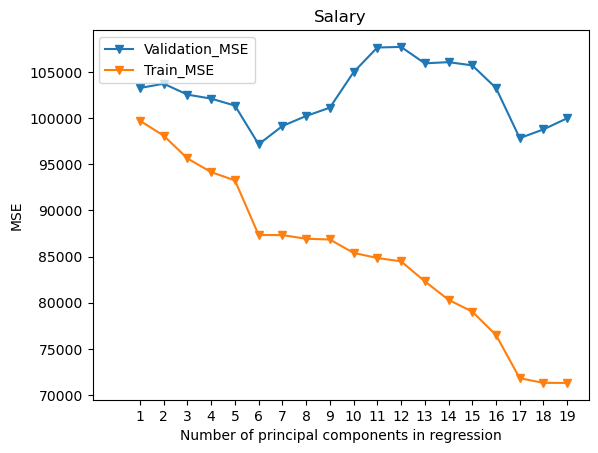

In [670]:
mse_train = []
mse_cv = []

for i in np.arange(1, 20):
    results =  pcr(X_train,y_train,i)
    mse_train.append(results[3])
    mse_cv.append(results[4])
    
plt.plot(np.arange(1, 20), mse_cv, '-v', label = 'Validation_MSE')
plt.plot(np.arange(1, 20), mse_train, '-v', label = 'Train_MSE')
plt.xlabel('Number of principal components in regression')
plt.ylabel('MSE')
plt.title('Salary')
plt.xlim(left=-1)
plt.xticks(np.arange(1,20))
plt.legend()
plt.show()

Note pelo gráfico acima que o menor MSE é atingido com 6 componentes principais. Como esperado, quanto mais PCs, menor o MSE de treino, mas note que basicamente para qualquer número de PCs o erro de validação (i.e., CV) é maior do que de treino.

Usando 6 PCs, qual é o MSE de teste que atingimos?

In [671]:
pc_max = 20

pca = PCA()
X_reduced_train = pca.fit_transform(scale(X_train))
X_reduced_test = pca.transform(scale(X_test))[:, :pc_max]
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_reduced_train[:, :pc_max], y_train)

pred = linear_regression.predict(X_reduced_test)
mean_squared_error(y_test, pred)

186974.5171492781

Isso é um pouco melhor do que ridge, que atingiu 186992 (tanto lasso quanto regressão linear tiveram MSEs maiores).

## Mínimos quadrados parciais

Será que conseguimos melhorar ainda mais o resultado de PCR? Vamos tentar PLS.

In [678]:
n_components = 4

pls = PLSRegression(n_components=n_components)
pls.fit(scale(X_train), y_train)

mean_squared_error(y_test, pls.predict(scale(X_test)))

188954.27712275396

O MSE parece na mesma faixa que PCR e ridge. Mas aqui escolhemos um número de componentes arbitrário. Qual seria uma maneira mais rigorosa de escolher esse parâmetro?